# Amazon Reviews Sentiment Analysis - Ferri Marco, Basso Matteo

This project aims to experiment with sentiment analysis on [Amazon Reviews](http://jmcauley.ucsd.edu/data/amazon/) in order to build a prediction model for rating, based on NLP.

## Dataset

### Dependencies

In [0]:
import os
import gzip
import fileinput
import sys
import datetime
import io
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading


Util functions to read from JSON and convert into pandas dataframe:

In [0]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):      
    basepath = r"datasets\amazon-5-core"
    df = getDF(os.path.join(basepath, dataset))
    return df
  
def download_dataset(dataset):
    request = urllib.request.Request('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/' + dataset)
    request.add_header('Accept-encoding', 'gzip')
    response = urllib.request.urlopen(request)
    buf = io.BytesIO(response.read())
    file = gzip.GzipFile(fileobj=buf)
    df = []
    for line in file:
      df.append(eval(line))
    return pd.DataFrame(df)

Reading from JSON

In [0]:
#%time dfull = read_dataset("reviews_Video_Games_5.json.gz")
%time dfull = download_dataset('reviews_Video_Games_5.json.gz')

CPU times: user 15.9 s, sys: 312 ms, total: 16.3 s
Wall time: 22.5 s


Columns renaming

In [0]:
dfull = dfull.rename(index=str, columns={"asin": "productID", 
                                         "reviewerID": "userID", 
                                         "reviewerName": "userName",
                                         "reviewText": "text",
                                         "overall": "rating"})

#### Reading performance

!pip install py-heat-magic
%load_ext heat

%%heat
import os
import gzip
import fileinput
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):
    basepath = r"datasets\amazon-5-core"
    df = getDF(os.path.join(basepath, dataset))
    return df

dfull = read_dataset("reviews_Video_Games_5.json.gz")

![reading performances](https://github.com/mferri17/amazon-reviews-sentiment-network-analysis/blob/master/docs/images/00_dataset_reading_performances.png?raw=true)

---

###  Description

#### Schema

In [0]:
dfull.shape

(231780, 9)

In [0]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231780 entries, 0 to 231779
Data columns (total 9 columns):
productID         231780 non-null object
helpful           231780 non-null object
rating            231780 non-null float64
text              231780 non-null object
reviewTime        231780 non-null object
userID            231780 non-null object
userName          228967 non-null object
summary           231780 non-null object
unixReviewTime    231780 non-null int64
dtypes: float64(1), int64(1), object(7)
memory usage: 17.7+ MB


Little dataset preview:

In [0]:
dfull.head(3)

,productID,helpful,rating,text,reviewTime,userID,userName,summary,unixReviewTime
0,0700099867,"[8, 12]",1.0,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000
1,0700099867,"[0, 0]",4.0,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400
2,0700099867,"[0, 0]",1.0,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600


#### Columns analysis

##### Users and products

In [0]:
(rows,cols) = dfull.shape
n_users = dfull['userID'].nunique()
n_products = dfull['productID'].nunique()
print("Number of REVIEWS: ", rows)
print("Number of USERS: ", n_users)
print("Number of PRODUCTS: ", n_products)
print("Avarage REVIEWS PER USER: ", rows/n_users)
print("Avarage REVIEWS PER PRODUCT: ", rows/n_products)

Number of REVIEWS:  231780
Number of USERS:  24303
Number of PRODUCTS:  10672
Avarage REVIEWS PER USER:  9.537094185902975
Avarage REVIEWS PER PRODUCT:  21.718515742128936


##### Datetime

In [0]:
dfull['date'] = pd.to_datetime(dfull['unixReviewTime'],unit='s')
print("First date: ", min(dfull['date']))
print("Last date: ", max(dfull['date']))

First date:  1999-10-14 00:00:00
Last date:  2014-07-22 00:00:00


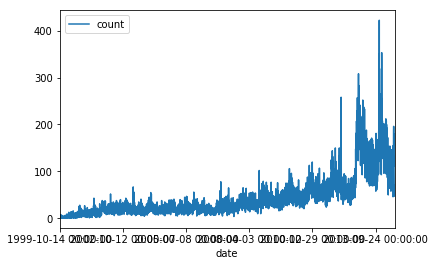

In [0]:
date_grouping = dfull.groupby('date').count()[['rating']].sort_values('date', ascending=True)
date_grouping = date_grouping.rename(index=str, columns={"rating": "count"})
date_grouping.plot()

##### Rating

In [0]:
dfull['rating'].mean()

4.086396582966606

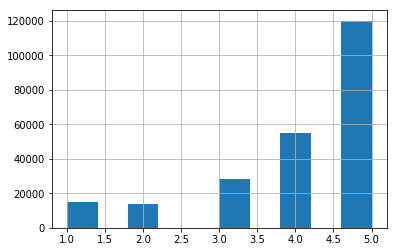

In [0]:
dfull['rating'].hist()

***

## Sentiment Analysis

### Dependencies

In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from PIL import Image
from wordcloud import WordCloud

from collections import Counter
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score
from wordcloud import WordCloud

### Text pre-processing

In [0]:
stopset = set(stopwords.words('english'))
stopset

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

### Common Words

In [0]:
import itertools

sentences = (list(itertools.chain(dfull)))
flat_list = [item for sublist in sentences for item in sublist]
  
fig = plt.figure(figsize=(20,14))
wordcloud = WordCloud(background_color="white").generate(" ".join(flat_list))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")

ValueError: ignored

<Figure size 1440x1008 with 0 Axes>

---

## Rating prediction

### Data manipulation

#### Rejecting columns

In [0]:
dfull = dfull.drop(['helpful', 'reviewTime', 'unixReviewTime', 'userName'], axis = 1)

#### Binarization

In [0]:
dfull['sentiment'] = ['positive' if r > 3 else 'negative' for r in dfull['rating']]
dfull['sentiment'].value_counts()
#dfull.sentiment.hist()

positive    174989
negative     56791
Name: sentiment, dtype: int64

#### Undersampling

In [0]:
from sklearn.utils import *

# Separate majority and minority classes
df_majority = dfull[dfull.sentiment=='positive']
df_minority = dfull[dfull.sentiment=='negative']
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=dfull['sentiment'].value_counts()['negative'],     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['sentiment'].value_counts()

negative    56791
positive    56791
Name: sentiment, dtype: int64

### Learning

#### Train and test set

#### Model

### Prediction

### Performance